*Предисловие.*

*В процессе работы над задачей я несколько раз пересматривала подход. Ниже представлен ход мыслей, который частично оказался тупиковым, и я потом это поняла, но редактировать описание не стала.*

*Если коротко, то я попробовала подойти к решению этой задачи, используя различные классические модели ML для классификации и регресии с дефолтными гиперпараметрами для первоначальной оценки качества, а потом реализовала модель из области survival analysis.*

# Прогноз отказа мотора на основе показаний датчиков

__Описание данных__
* id -- идентификатор мотора
* cycle -- цикл работы
* p00-p20 -- показания датчиков считываемые в процессе работы
* s0, s1 -- настройки изменяемые в конце каждого цикла

Необходимо предложить решение задачи прогнозирования отказа моторов и варианты использования этого решения на практике.
Считаем, что максимальный цикл мотора в данных -- это последний цикл перед поломкой.
Нужно предложить варианты использования полученной модели на практике.

#### Импорт библиотек и загрузка данных <a class="anchor" id="first-bullet"></a>

In [348]:
import pandas as pd
import numpy as np
from IPython.display import display
import warnings
#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
#sklearn
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, plot_confusion_matrix, confusion_matrix, \
                            mean_squared_error, r2_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#Анализ выживаемости
from lifelines import AalenAdditiveFitter
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,397,2388,100,644.00,38.39,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,396,2388,100,643.81,38.34,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,397,2388,100,643.49,38.34,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,397,2388,100,643.83,38.53,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002


### Добавление целевого признака
Задача бинарной классификации в данном случае предполает отнесение образца данных к одному из двух классов:
* 1 - осталось n циклов работы мотора до поломки
* 0 - до поломки не n циклов

где n - число, которое нам необходимо определить аналитически, однако предварительно возьмем n равное 10. Далее скорректируем это значение, когда построим модель и вычислим доверительные интервалы.

Добавим 2 столбца:
* cycles_before_breakage - количество циклов до поломки [0, m)
* target - целевое значение, определяет класс 0 или 1

In [6]:
df = df.sort_values(by=['id', 'cycle'])
df['cycles_before_breakage'] = df.groupby('id')['cycle'].cumcount(ascending=False)
df['target'] = df['cycles_before_breakage'].apply(lambda x: 1 if x == 10 else 0)

### Распределение целевого признака
Проверим, нормально ли работает функция установки таргета и одновременно посмотрим на баланс классов

In [33]:
df[df['cycles_before_breakage'] == 10]['target'].value_counts(), df[df['cycles_before_breakage'] != 10]['target'].value_counts()

(1    80
 Name: target, dtype: int64,
 0    16058
 Name: target, dtype: int64)

Тут явный (и вполне ожидаемый) дисбаланс классов, в дальнейшем его надо скорректировать

## 1. Очистка и предварительный анализ данных

In [43]:
df.shape

(16138, 27)

In [53]:
df.dtypes

id                          int64
cycle                       int64
p00                       float64
p01                       float64
p02                       float64
p03                       float64
p04                       float64
p05                       float64
p06                       float64
p07                       float64
p08                         int64
p09                         int64
p10                         int64
p11                       float64
p12                       float64
p13                       float64
p14                       float64
p15                       float64
p16                       float64
p17                       float64
p18                       float64
p19                       float64
p20                       float64
s1                        float64
s2                        float64
cycles_before_breakage      int64
target                      int64
dtype: object

### 1.1. Посмотрим количество уникальных значений в колонках, чтобы выявить потенциальные категориальные данные и колонки с одним значением

In [105]:
col_nunique = df[col_list].nunique()
col_nunique

p00       1
p01       1
p02     156
p03     418
p04      56
p05    5707
p06    1871
p07       1
p08      12
p09       1
p10       1
p11     307
p12     116
p13    4518
p14    2899
p15    3865
p16       1
p17       2
p18     502
p19      53
p20    5955
s1      155
s2       13
dtype: int64

__Удалим из датасета колонки с только одним значением, т.к. он никак не поможет нам в задаче прогнозирования поломки__

In [107]:
df = df.drop(list(col_nunique[col_nunique == 1].index), axis=1)

__Запоним признаки, которые могут быть категориальными для дальнейшей их оценки__

In [108]:
cat_col_possible = list(col_nunique[col_nunique <= 15].index)

__Обозначим список колонок с датчиками и настройками (Pnn и Sn) для дальнейшей работы с ними__

In [141]:
p_col_list = [] # названия столбцов с показаниями датчиков p
s_col_list = [] # названия столбцов с показаниями настроек s 
col_list = []   # названия столбцов с показаниями датчиков и настроек

for col in df.columns:
    if col.startswith('p'):
        p_col_list.append(col)
        col_list.append(col)
    elif col.startswith('s'):
        s_col_list.append(col)
        col_list.append(col)
        
print('Кол-во столбцов p_col_list:', len(p_col_list))
print('Кол-во столбцов s_col_list:', len(s_col_list))
print('Кол-во столбцов col_list:', len(col_list))

Кол-во столбцов p_col_list: 15
Кол-во столбцов s_col_list: 4
Кол-во столбцов col_list: 19


### 1.2. Отсутсвующие значения

In [41]:
df.isna().mean()*100

id                        0.0
cycle                     0.0
p00                       0.0
p01                       0.0
p02                       0.0
p03                       0.0
p04                       0.0
p05                       0.0
p06                       0.0
p07                       0.0
p08                       0.0
p09                       0.0
p10                       0.0
p11                       0.0
p12                       0.0
p13                       0.0
p14                       0.0
p15                       0.0
p16                       0.0
p17                       0.0
p18                       0.0
p19                       0.0
p20                       0.0
s1                        0.0
s2                        0.0
cycles_before_breakage    0.0
target                    0.0
dtype: float64

Пропущенных данных нет

### 1.3. Оценка выбросов
Специфика задачи подразумевает наличие значений, которые нельзя считать выбросами, т.к. показатели датчиков перед поломкой могут зашкаливать. Но все же посмотрим, есть ли такие выбросы

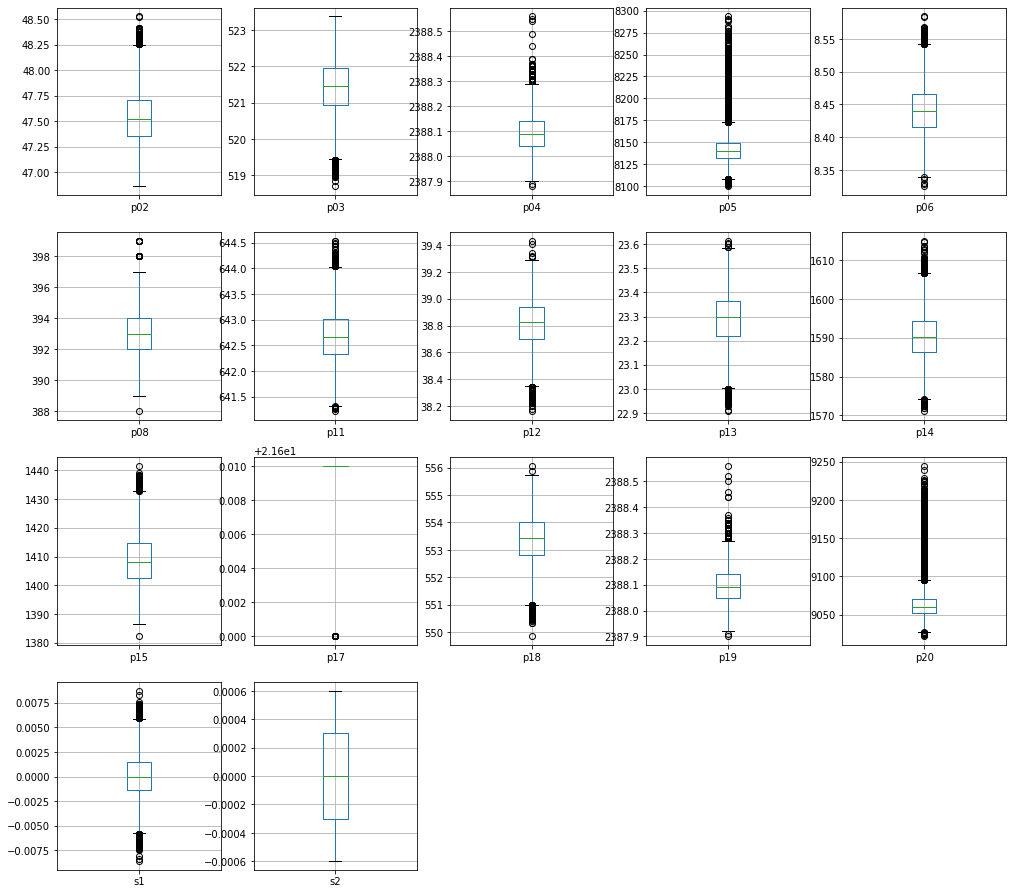

In [115]:
plt.figure(figsize=[17, 20])

i = 1

for f in col_list:
    plt.subplot(5, 5, i)
    df.boxplot(column=f)
    i += 1
plt.show()

Да, выбросы есть, однако трогать их пока не будем, т.к. 
* они могут быть связаны с приближением поломки мотора
* количество циклов работы разных моторов значительно отличается, но не по причине того, что какой-то мотор качественнее, а потому, что первая часть циклов работы мотора могла быть не записана в датасет (начало нумерации циклов в датасете моет не соответсвовать действительной нумерации)*

*Если в датасете оставить у всех моторов одинаковое кол-во циклов до поломки и отразить значения всех показателей как временной ряд, то будет видно, что разброс различных показателей у разных моторов на каждом цикле не значительный:

### 1.4. Анализ признаков

In [120]:
min_num_cycles = min(df.groupby('id')['cycle'].max())
df_fix_cycles = df[df['cycles_before_breakage'] < min_num_cycles]
df_fix_cycles['cycle_new'] = df_fix_cycles.groupby('id')['cycles_before_breakage'].cumcount(ascending=True)

Изменение показаний датчиков P с каждым последующим циклом вплоть до поломки


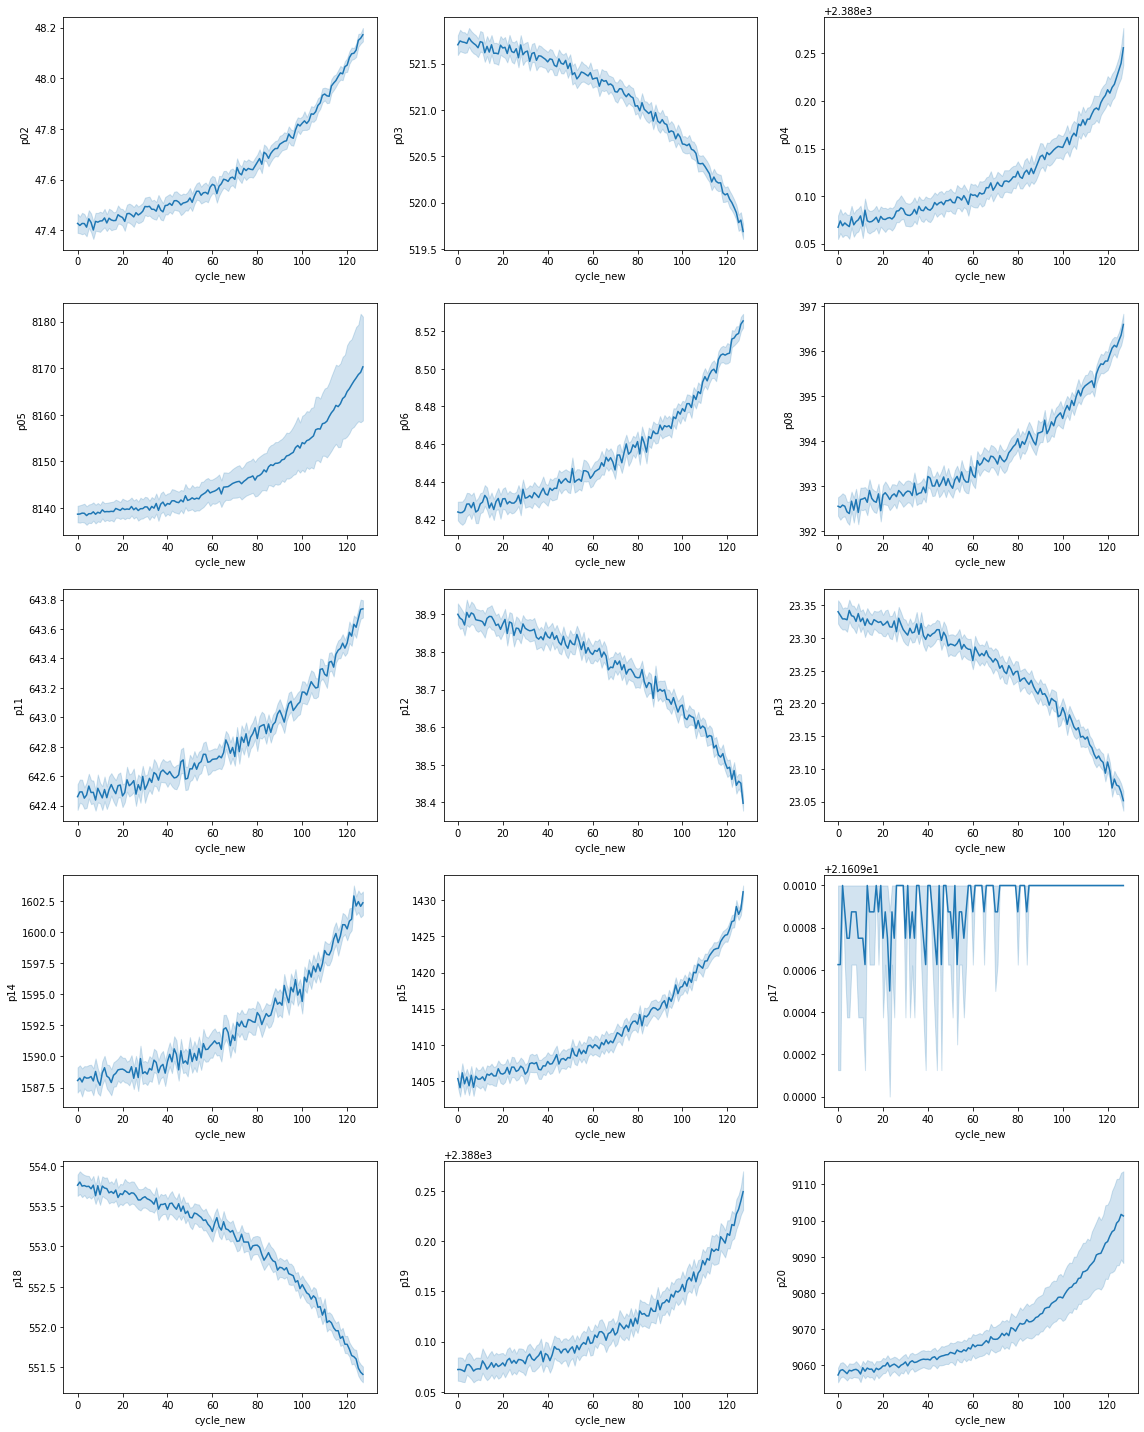

In [116]:
print('Изменение показаний датчиков P с каждым последующим циклом вплоть до поломки')

plt.figure(figsize=[16, 20])

i = 1

for f in p_col_list:
    plt.subplot(5, 3, i)
    sns.lineplot(data=df_fix_cycles, x="cycle_new", y=f)
    i += 1
plt.tight_layout()
plt.show()

Мы видим, что график Р17 отличается от других, но пока нельзя сказать, что он не поможет нам в определении поломки. Поскольку мы видим, что ближе к поломке (примерно за 35 циклов до) данный показатель закрепляется на одном значение и остается неизменным во всех случаях наблюдений. Для данного показателя имеет смысл рассчитать новый показатель, который отражал бы количество циклов, в течении которых данный показатель остается неизменным.

У показателей Р05 и Р20 ближе к поломке увеличивается разброс, что может усложнить прогноз поломки. При этом мы видем, что они очень схожи.

Остальные показатели очень ведут себя схоже, различась лишь направлением изменения.

Такую же зависимость можно увидеть в матрице корреляции:

<AxesSubplot:>

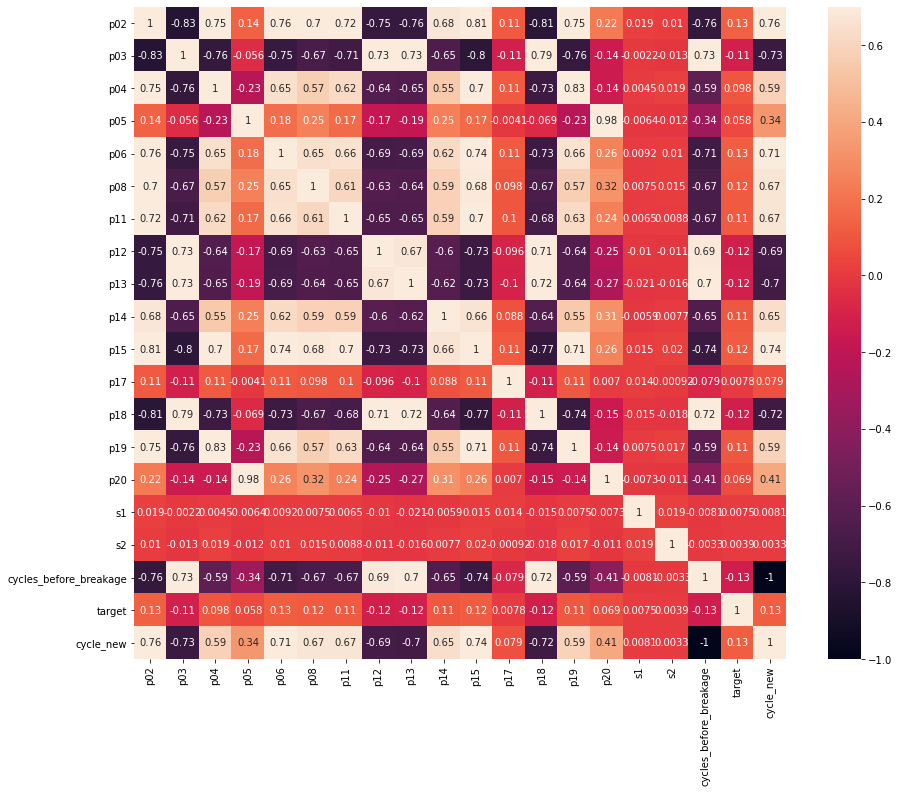

In [121]:
corr = df_fix_cycles[df_fix_cycles.columns[2:]].corr()

fig,ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=.7, square=True,annot=True)

Сильно коррелированные друг с другом переменные дают модели одну и ту же информацию, следовательно, для анализа не нужно использовать их все.
Вот и подобрались к отбору признаков.

## 2. Работа с признаками

Задачу определения признаков, которые будут использованы для обучения модели, разобьем на несколько подзадач:
1. решить, что делать с коррелирующими друг с другом признаками p 2, 3, 4, 6, 8, 11, 12, 13, 14, 15, 18, 19.
2. разобраться с признаками настроек s
3. разобраться с р17
4. решить, что делать с p05 и p20, которые почти одинаковы и имеют довольно сильный разброс по отношению к циклам работы, что может помешать прогнозированию

### 2.1. Признаки  p2, 3, 4, 6, 8, 11, 12, 13, 14, 15, 18, 19.
Я вижу 2 варианта работы с данными признаками:
* оставить только один признак, наиболее коррелирующий с циклами

* применить метод понижения размерности, но у меня нет такого опыта и для этого нужно больше времени

Оставим только p2, т.к. у него наибольшая корреляция с циклом.

Добавлю лист с названиями признаков, которые будут использоваться для обучения:

In [268]:
model_features = df.columns.tolist()
print(model_features)

['id', 'cycle', 'p02', 'p03', 'p04', 'p05', 'p06', 'p08', 'p11', 'p12', 'p13', 'p14', 'p15', 'p17', 'p18', 'p19', 'p20', 's1', 's2', 'cycles_before_breakage', 'target', 's1_fact', 's2_fact', 's1_fact^2', 's2_fact^2', 's1^2', 's2^2']


In [271]:
model_features = ['p02', 'p05', 'p17', 'p20', 's1', 's2', 's1_fact', 's2_fact', 's1_fact^2', 's2_fact^2', 's1^2', 's2^2']

### 2.2. Поиск зависимости признаков s с циклами, таргетом и показателями датчиков

Добавим куммулятивные показатели s:

In [123]:
df['s1_fact'] = df.groupby('id')['s1'].transform(lambda x: x.cumsum().shift(fill_value=0))
df['s2_fact'] = df.groupby('id')['s2'].transform(lambda x: x.cumsum().shift(fill_value=0))

Сдвинем показатели s1 и s2 на ячейку вниз внутри группы, чтобы в каждой записи были настройки, определенные перед циклом, т.к. они, вероятно, влияют на показания датчиков.

In [130]:
df['s1'] = df.groupby('id')['s1'].transform(lambda x: x.shift(fill_value=0))
df['s2'] = df.groupby('id')['s2'].transform(lambda x: x.shift(fill_value=0))

Добавим квадраты показателей s

In [254]:
df['s1_fact^2'] = df['s1_fact']**2
df['s2_fact^2'] = df['s2_fact']**2
df['s1^2'] = df['s1']**2
df['s2^2'] = df['s2']**2

In [255]:
df

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2,cycles_before_breakage,target,s1_fact,s2_fact,s1_fact^2,s2_fact^2,s1^2,s2^2
0,1,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06,9046.19,0.0000,0.0000,191,0,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,2,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04,9044.07,-0.0007,-0.0004,190,0,-0.0007,-0.0004,4.900000e-07,1.600000e-07,4.900000e-07,1.600000e-07
2,1,3,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08,9052.94,0.0019,-0.0003,189,0,0.0012,-0.0007,1.440000e-06,4.900000e-07,3.610000e-06,9.000000e-08
3,1,4,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11,9049.48,-0.0043,0.0003,188,0,-0.0031,-0.0004,9.610000e-06,1.600000e-07,1.849000e-05,9.000000e-08
4,1,5,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06,9055.15,0.0007,0.0000,187,0,-0.0024,-0.0004,5.760000e-06,1.600000e-07,4.900000e-07,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8218.63,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,21.61,552.24,2388.20,9145.62,0.0005,-0.0002,4,0,-0.0115,-0.0022,1.322500e-04,4.840000e-06,2.500000e-07,4.000000e-08
16134,80,182,48.41,520.06,2388.12,8221.91,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,21.61,551.60,2388.16,9160.23,0.0042,0.0002,3,0,-0.0073,-0.0020,5.329000e-05,4.000000e-06,1.764000e-05,4.000000e-08
16135,80,183,48.04,519.67,2388.21,8217.46,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,21.61,551.78,2388.12,9152.84,-0.0014,0.0004,2,0,-0.0087,-0.0016,7.569000e-05,2.560000e-06,1.960000e-06,1.600000e-07
16136,80,184,48.04,519.72,2388.20,8228.65,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,21.61,551.78,2388.17,9164.10,0.0018,0.0000,1,0,-0.0069,-0.0016,4.761000e-05,2.560000e-06,3.240000e-06,0.000000e+00


Дальше попробуем работать с обрезанными данными, где у всех моторов одинаковое кол-во циклов работы до поломки.

In [258]:
min_num_cycles = min(df.groupby('id')['cycle'].max())
df_fix_cycles = df[df['cycles_before_breakage'] < min_num_cycles]
df_fix_cycles['cycle_new'] = df_fix_cycles.groupby('id')['cycles_before_breakage'].cumcount(ascending=True)
df_fix_cycles = df_fix_cycles.drop(['cycle'], axis=1)
df_fix_cycles.head(3 )

,id,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2,cycles_before_breakage,target,s1_fact,s2_fact,s1_fact^2,s2_fact^2,s1^2,s2^2,cycle_new
64,1,47.56,521.54,2388.13,8132.94,8.4406,392,642.28,38.90,23.3752,1584.72,1403.24,21.61,553.97,2388.03,9044.01,0.0017,0.0002,127,0,-0.0234,0.0025,0.000548,0.000006,2.890000e-06,4.000000e-08,0
65,1,47.14,521.76,2388.05,8128.32,8.3911,391,642.50,38.95,23.3152,1588.50,1399.52,21.61,554.00,2388.06,9059.45,0.0000,0.0005,126,0,-0.0234,0.0030,0.000548,0.000009,0.000000e+00,2.500000e-07,1
66,1,47.39,522.64,2388.08,8134.07,8.3925,393,642.33,38.97,23.2910,1590.22,1403.02,21.61,554.31,2388.10,9050.24,-0.0007,-0.0004,125,0,-0.0241,0.0026,0.000581,0.000007,4.900000e-07,1.600000e-07,2


Поменяем порядок столбцов для удобства:

In [259]:
cols = df_fix_cycles.columns.tolist()
cols

['id',
 'p02',
 'p03',
 'p04',
 'p05',
 'p06',
 'p08',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p17',
 'p18',
 'p19',
 'p20',
 's1',
 's2',
 'cycles_before_breakage',
 'target',
 's1_fact',
 's2_fact',
 's1_fact^2',
 's2_fact^2',
 's1^2',
 's2^2',
 'cycle_new']

In [260]:
cols = ['id', 'cycle_new', 'cycles_before_breakage', 'p02', 'p03', 'p04', 'p05', 'p06', 'p08', 'p11', 'p12', 'p13', 'p14', 'p15', 'p17', 'p18', 'p19', 'p20',
 's1',
 's2',
 's1_fact',
 's2_fact',
 's1_fact^2',
 's2_fact^2',
 's1^2',
 's2^2',
 'target']

df_fix_cycles = df_fix_cycles[cols]
df_fix_cycles.head(3)

,id,cycle_new,cycles_before_breakage,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2,s1_fact,s2_fact,s1_fact^2,s2_fact^2,s1^2,s2^2,target
64,1,0,127,47.56,521.54,2388.13,8132.94,8.4406,392,642.28,38.90,23.3752,1584.72,1403.24,21.61,553.97,2388.03,9044.01,0.0017,0.0002,-0.0234,0.0025,0.000548,0.000006,2.890000e-06,4.000000e-08,0
65,1,1,126,47.14,521.76,2388.05,8128.32,8.3911,391,642.50,38.95,23.3152,1588.50,1399.52,21.61,554.00,2388.06,9059.45,0.0000,0.0005,-0.0234,0.0030,0.000548,0.000009,0.000000e+00,2.500000e-07,0
66,1,2,125,47.39,522.64,2388.08,8134.07,8.3925,393,642.33,38.97,23.2910,1590.22,1403.02,21.61,554.31,2388.10,9050.24,-0.0007,-0.0004,-0.0241,0.0026,0.000581,0.000007,4.900000e-07,1.600000e-07,0


Посмотрим, как меняется s_fact с течением времени

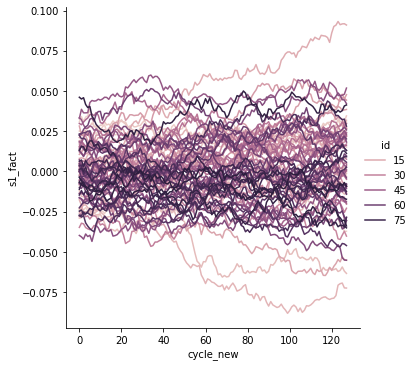

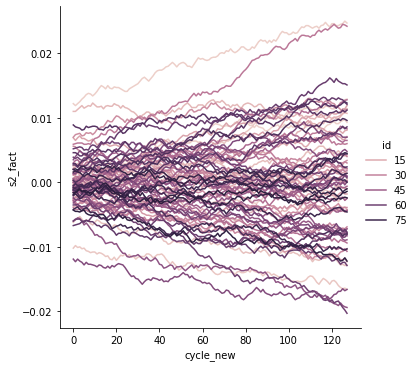

In [206]:
sns.relplot(x='  ', y='s1_fact', hue='id', kind='line', ci=None, data=df_fix_cycles)
sns.relplot(x='cycle_new', y='s2_fact', hue='id', kind='line', ci=None, data=df_fix_cycles)

Красиво, но зависимость от цикла не прослеживается. Складывать показатели не имеет смысла, уже пробовала. Попробую возвести в квадрат

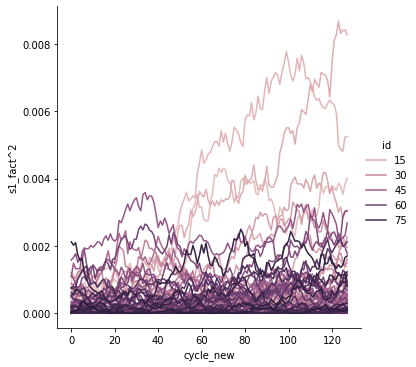

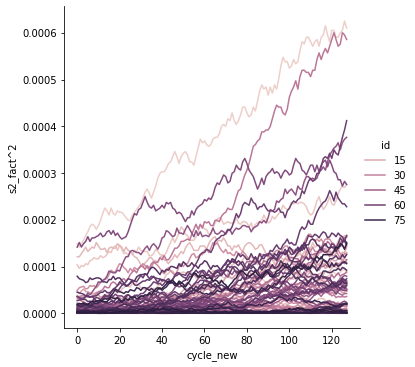

In [246]:
sns.relplot(x='cycle_new', y='s1_fact^2', hue='id', kind='line', ci=None, data=df_fix_cycles)
sns.relplot(x='cycle_new', y='s2_fact^2', hue='id', kind='line', ci=None, data=df_fix_cycles)

Еще раз посмотрим на корреляцию:

'\nplt.subplot(132).set_title("kendall")\ncorr = df_fix_cycles.corr(\'kendall\')[[\'s1\', \'s2\', \'s1_fact\', \'s2_fact\', \'s1_fact^2\', \'s2_fact^2\', \'s1^2\', \'s2^2\']]\nsns.heatmap(corr, vmax=.7, square=True,annot=True)\n\nplt.subplot(133).set_title("spearman")\ncorr = df_fix_cycles.corr(\'spearman\')[[\'s1\', \'s2\', \'s1_fact\', \'s2_fact\', \'s1_fact^2\', \'s2_fact^2\', \'s1^2\', \'s2^2\']]\nsns.heatmap(corr, vmax=.7, square=True,annot=True)\n'

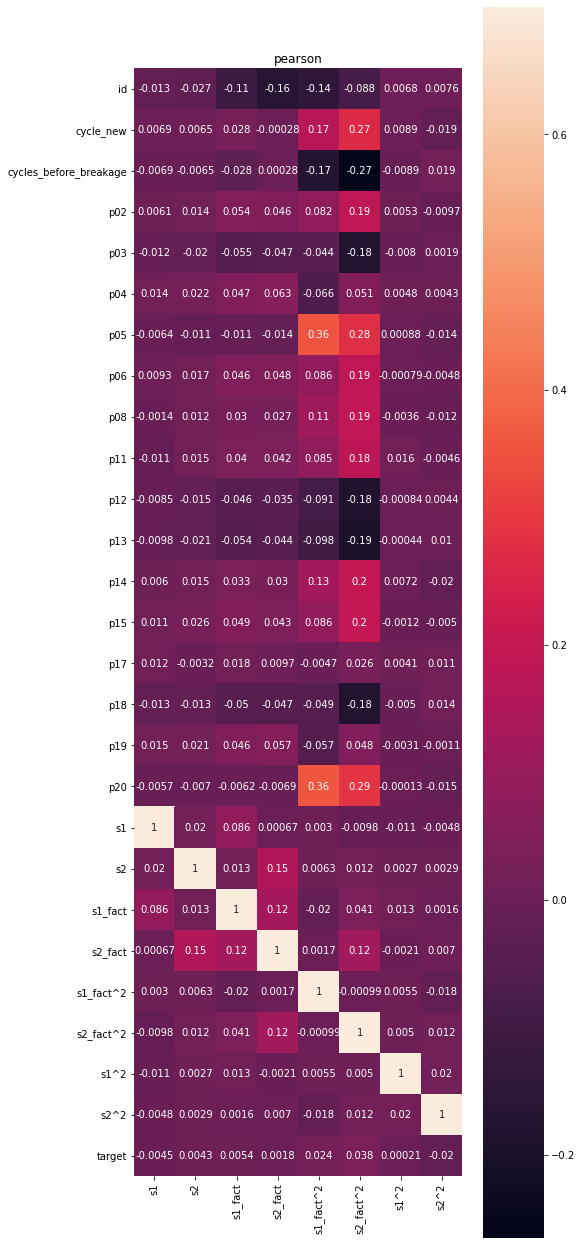

In [264]:
plt.figure(figsize=[25, 30])

plt.subplot(131).set_title("pearson")
corr = df_fix_cycles.corr('pearson')[['s1', 's2', 's1_fact', 's2_fact', 's1_fact^2', 's2_fact^2', 's1^2', 's2^2']]
sns.heatmap(corr, vmax=.7, square=True,annot=True)
'''
plt.subplot(132).set_title("kendall")
corr = df_fix_cycles.corr('kendall')[['s1', 's2', 's1_fact', 's2_fact', 's1_fact^2', 's2_fact^2', 's1^2', 's2^2']]
sns.heatmap(corr, vmax=.7, square=True,annot=True)

plt.subplot(133).set_title("spearman")
corr = df_fix_cycles.corr('spearman')[['s1', 's2', 's1_fact', 's2_fact', 's1_fact^2', 's2_fact^2', 's1^2', 's2^2']]
sns.heatmap(corr, vmax=.7, square=True,annot=True)
'''

Коррелция у s_fact^2 выше, попробуем их включить в модель.
Также я пробовала различные комбинации настроек s, чтобы выявить большую зависимость с циклами до поломки или использовать их для уменьшения разброса p20 и p05, но мне пока это не удалось. Расчеты не стала сюда включать, т.к. они громоздкие.

In [273]:
model_features = ['p02', 'p05', 'p17', 'p20', 's1_fact^2', 's2_fact^2']

### 2.3. Признаки p20, p5

Поскольку p20 и p5 коррелируют на 98%, оставлять обоих нельзя. При этом p20 также имеет средний уровень корреляции с показателем р2, но я все же попробую оставить его для разнообразия признаков.

In [274]:
model_features = ['p02', 'p17', 'p20', 's1_fact^2', 's2_fact^2']

### 2.4. Признак p17

In [278]:
df['p17'].value_counts()

21.61    15807
21.60      331
Name: p17, dtype: int64

P17 - бинарный категориальный признак.

In [280]:
df[df['p17'] == 21.60]['id'].nunique()

46

Чуть больше половины моторов хоть раз переключались в значение р17 21.60.

В качестве варианта его использования можно было бы рассмотреть создание признака, который отражал бы количество циклов, когда p17 остается неизменным и имеет значение 21.61 (т.к. данное значение имеют все без исключения моторы последние несколько циклов перед поломкой). Однако в данном случае это не имеет смысла, т.к. количество значений 21.60 и количество моторов, которые хоть раз показывали данное значение, не достаточно, чтобы помочь в предсказании.

В связи с этим признак р17 исключаем из данных для модели.

In [335]:
model_features = ['p02', 'p20', 's1_fact^2', 's2_fact^2']

__Составлен первый вариант списка признаков для модели, продолжим предварительную обработку данных обработку данных__

# 3. Выбор модели

## 3.1. Попробуем решить задачу классификации

*И тут начались разочарования, т.к. классические модели классификации плохо работали с этими данными.*

Данная задача предполагает дисбаланс классов 1, сэмплирование может негативно сказаться на качестве модели, поэтому попробуем обойтись без него. Чтобы минимизировать риск, связанный с дисбалансом классов, в качестве обучающего алгоритма будем использовать вероятностную модель (Логистическую регрессию или модели на основе деревьев решений).

In [336]:
X = df[model_features]
y = df['target']

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], random_state=0)

### 3.1.1. Возьмем несколько базовых моделей и посмотрим сначала, как они работают на дефолтных параметрах.
__В качестве основной метрики я выбрала F1, т.к. в данной задаче нам важен класс 1, но при этом почти одинаково важно, чтобы не было слишком много как ложноположительных, так и ложноотрицательных предсказаний (в первом случае мы разоримся на ненужном техобслуживании, в другом - на запоздалом ремонте).__

Для логистической регрессии надо бы масштабировать данные, но я пока попробую так.

In [380]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

В качестве метрики я взяла взвешенную f1, т.к. ее советуют при дисбалансе классов. Я так и не поняла, почему она показала такие странные значения, т.к. конфьюжн матрица показала очевидную неработоспособность модели для предсказания класса 1.

LogisticRegression()


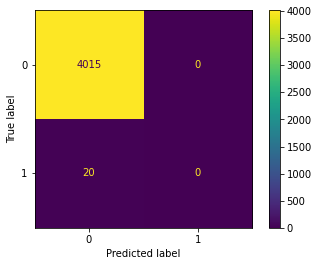

DecisionTreeClassifier()


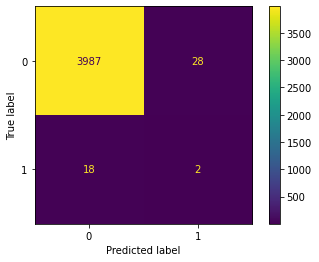

RandomForestClassifier()


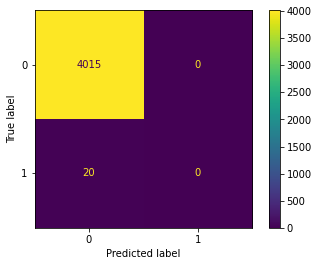

GradientBoostingClassifier()


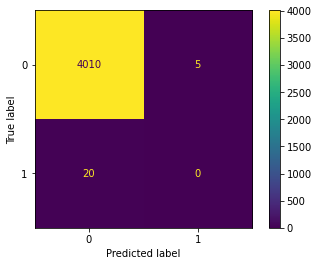

  Name     Score
0   LR  0.992571
1   DT  0.989733
2   RF  0.992571
3   GB  0.991951


In [385]:
names = []
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model)
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show()  
    scores.append(f1_score(y_test, y_pred, average='weighted'))
    names.append(name)
    tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

Стало очевидно, что необходимо разобраться с дисбалансом классов.

### 3.1.2. Корректировка дисбаланса классов

In [395]:
df['target'].value_counts()[1] / df['target'].value_counts()[0] * 100

0.49819404658114336

Сократим класс 0

In [396]:
min_num_cycles = min(df.groupby('id')['cycle'].max())
df_fix_cycles = df[df['cycles_before_breakage'] < min_num_cycles]
df_fix_cycles['cycle_new'] = df_fix_cycles.groupby('id')['cycles_before_breakage'].cumcount(ascending=True)
df_fix_cycles = df_fix_cycles.drop(['cycle'], axis=1)
df_fix_cycles.head(3)

,id,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2,cycles_before_breakage,target,s1_fact,s2_fact,s1_fact^2,s2_fact^2,s1^2,s2^2,cycle_new
64,1,47.56,521.54,2388.13,8132.94,8.4406,392,642.28,38.90,23.3752,1584.72,1403.24,21.61,553.97,2388.03,9044.01,0.0017,0.0002,127,0,-0.0234,0.0025,0.000548,0.000006,2.890000e-06,4.000000e-08,0
65,1,47.14,521.76,2388.05,8128.32,8.3911,391,642.50,38.95,23.3152,1588.50,1399.52,21.61,554.00,2388.06,9059.45,0.0000,0.0005,126,0,-0.0234,0.0030,0.000548,0.000009,0.000000e+00,2.500000e-07,1
66,1,47.39,522.64,2388.08,8134.07,8.3925,393,642.33,38.97,23.2910,1590.22,1403.02,21.61,554.31,2388.10,9050.24,-0.0007,-0.0004,125,0,-0.0241,0.0026,0.000581,0.000007,4.900000e-07,1.600000e-07,2


In [398]:
df_fix_cycles['target'].value_counts()[1] / df_fix_cycles['target'].value_counts()[0] * 100

0.7874015748031495

In [410]:
X = df_fix_cycles[model_features]
y = df_fix_cycles['target']

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df_fix_cycles['target'], random_state=0)

Оверсемплинг данных недостающего класса:

In [416]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [418]:
y_res.value_counts()

0    7620
1    7620
Name: target, dtype: int64

### 3.1.3. Логистическая регрессия

#### Масштабирование признаков

In [426]:
from sklearn.preprocessing import MinMaxScaler

In [428]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [429]:
scaler.fit(X_res)
train = scaler.transform(X_res)
test = scaler.transform(X_test)

print('Формат тренировочной выборки: ', train.shape)
print('Формат тестовой выборки: ', test.shape)

Формат тренировочной выборки:  (15240, 4)
Формат тестовой выборки:  (2560, 4)


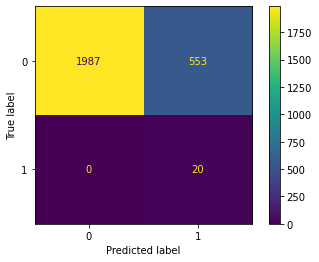

In [434]:
log_reg = LogisticRegression(C = 0.0001)

log_reg.fit(train, y_res)

log_reg_pred = log_reg.predict(test)
plot_confusion_matrix(log_reg, test, y_test)  
plt.show()

С такой моделью мы разоримся на ненужном техобслуживании.

### 3.1.4. Дерево решений

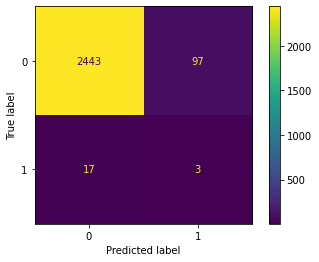

In [422]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_res, y_res)
y_pred_proba = model_dt.predict_proba(X_test)[:, 1]
y_pred = model_dt.predict(X_test)
plot_confusion_matrix(model_dt, X_test, y_test)  
plt.show()

Модель бесполезна.

### 3.1.5. Наивный байес

*Вдруг сработает*

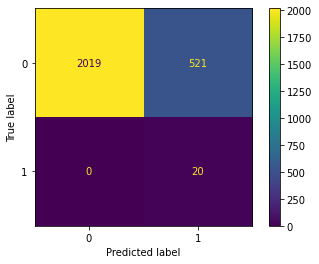

f1_score:  0.8793579019326329


In [425]:
from sklearn.naive_bayes import GaussianNB

X = df_fix_cycles[model_features]
y = df_fix_cycles['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df_fix_cycles['target'], random_state=0)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

clf = GaussianNB()
clf.fit(X_res, y_res)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
f1_score = f1_score(y_test, y_pred, average='weighted')
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()
print('f1_score: ', f1_score)

## 3.2. Модель регрессии

In [438]:
# Обрезка по циклам
min_num_cycles = min(df.groupby('id')['cycle'].max())
df_fix_cycles = df[df['cycles_before_breakage'] < min_num_cycles]
df_fix_cycles['cycle_new'] = df_fix_cycles.groupby('id')['cycles_before_breakage'].cumcount(ascending=True)
df_fix_cycles = df_fix_cycles.drop(['cycle'], axis=1)
df_fix_cycles.head(3)

,id,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2,cycles_before_breakage,target,s1_fact,s2_fact,s1_fact^2,s2_fact^2,s1^2,s2^2,cycle_new
64,1,47.56,521.54,2388.13,8132.94,8.4406,392,642.28,38.90,23.3752,1584.72,1403.24,21.61,553.97,2388.03,9044.01,0.0017,0.0002,127,0,-0.0234,0.0025,0.000548,0.000006,2.890000e-06,4.000000e-08,0
65,1,47.14,521.76,2388.05,8128.32,8.3911,391,642.50,38.95,23.3152,1588.50,1399.52,21.61,554.00,2388.06,9059.45,0.0000,0.0005,126,0,-0.0234,0.0030,0.000548,0.000009,0.000000e+00,2.500000e-07,1
66,1,47.39,522.64,2388.08,8134.07,8.3925,393,642.33,38.97,23.2910,1590.22,1403.02,21.61,554.31,2388.10,9050.24,-0.0007,-0.0004,125,0,-0.0241,0.0026,0.000581,0.000007,4.900000e-07,1.600000e-07,2


__Начнем с определения базовой модели__

### 3.2.1. Линейная регрессия (полином 2й степени)

Попробую за X взять только один признак Р02, т.к. он сильно коррелирует с кол-вом циклов

In [439]:
# выделение X и y
X = df_fix_cycles['p02']
y = df_fix_cycles['cycles_before_breakage']

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(X)
train = scaler.transform(X)
test = scaler.transform(X_test)

print('Формат тренировочной выборки: ', train.shape)
print('Формат тестовой выборки: ', test.shape)

In [443]:
x = X[:, np.newaxis]
y = y[:, np.newaxis]

In [448]:
x_poly

array([[1.0000000e+00, 4.7560000e+01, 2.2619536e+03],
       [1.0000000e+00, 4.7140000e+01, 2.2221796e+03],
       [1.0000000e+00, 4.7390000e+01, 2.2458121e+03],
       ...,
       [1.0000000e+00, 4.8040000e+01, 2.3078416e+03],
       [1.0000000e+00, 4.8040000e+01, 2.3078416e+03],
       [1.0000000e+00, 4.8050000e+01, 2.3088025e+03]])

In [445]:
polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

In [449]:
model = LinearRegression(normalize=False)
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

In [450]:
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

23.777601606028906
0.5858821914411072


### 3.2.2. Деревья решений

In [452]:
# выделение X и y
X = df_fix_cycles[model_features]
y = df_fix_cycles['cycles_before_breakage']

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df_fix_cycles['cycles_before_breakage'], random_state=0)

In [456]:
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

In [457]:
reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

In [459]:
rmse = np.sqrt(mean_squared_error(y_test, reg_tree_pred))
r2 = r2_score(y_test, reg_tree_pred)
print(rmse)
print(r2)

20.2890643210282
0.6984829657404729


### 3.2.3. Случайный лес

In [461]:
# выделение X и y
X = df_fix_cycles[model_features]
y = df_fix_cycles['cycles_before_breakage']

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df_fix_cycles['cycles_before_breakage'], random_state=0)

In [460]:
from sklearn.ensemble import RandomForestRegressor

In [481]:
rf_reg = RandomForestRegressor(n_estimators = 100)

rf_reg.fit(X_train, y_train)
rf_reg_pred = rf_reg.predict(X_test)

In [482]:
rmse = np.sqrt(mean_squared_error(y_test, rf_reg_pred))
r2 = r2_score(y_test, rf_reg_pred)
print(rmse)
print(r2)

18.298147975572213
0.7547539136891137


### 3.2.4. Градиентный бустинг

In [470]:
from sklearn.ensemble import GradientBoostingRegressor

In [475]:
gb_reg = GradientBoostingRegressor(n_estimators = 100)

gb_reg.fit(X_train, y_train)
gb_reg_pred = gb_reg.predict(X_test)

In [476]:
rmse = np.sqrt(mean_squared_error(y_test, gb_reg_pred))
r2 = r2_score(y_test, gb_reg_pred)
print(rmse)
print(r2)

18.932261687225207
0.7374616131891042


*В общем модели регрессии неплохо работают, и я думала развивать их, но тут я узнала об алгоритмах анализа выживаемости и попыталась разобраться в них.*

## 3.3. Решим задачу с помощью алгоритмов, относящихся к задаче анализа выживаемости

### 3.3.1. Модель Каплана-Мейера

Посмотрим на распределение моторов по количеству циклов:

<AxesSubplot:ylabel='Frequency'>

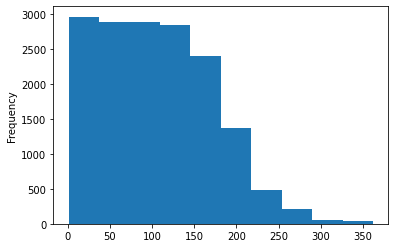

In [484]:
df['cycle'].plot(kind="hist")

Добавим столбец с метками 0 и 1, где 
* 0 - мотор после данного цикла работает, 
* 1 - мотор после данного цикла сломан.

In [496]:
df['Observed'] = df['cycles_before_breakage'].apply(lambda x: 1 if x==0 else 0)

Оценим функцию выживаемости с помощью библиотеки lifelines

In [498]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df['cycle'], event_observed=df['Observed'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 16138 total observations, 16058 right-censored observations>

Построим функцию "выживаемости":

<AxesSubplot:xlabel='timeline'>

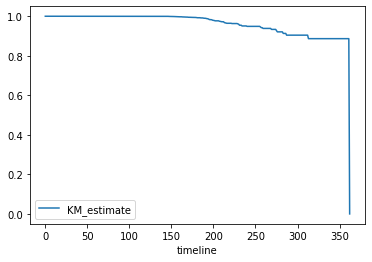

In [499]:
kmf.survival_function_.plot()

In [504]:
print(kmf.survival_function_.KM_estimate[300])
print(kmf.survival_function_.KM_estimate[330])

0.9043274507617199
0.8865955399624705


Построим функцию выживаемости, вместе с доверительными интервалами для вероятности:

<AxesSubplot:xlabel='timeline'>

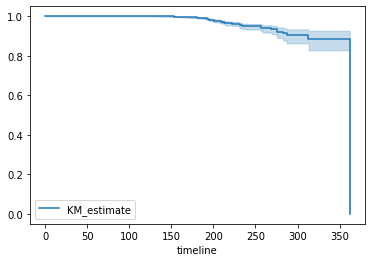

In [505]:
kmf.plot()

__Данная модель учитывает лишь цикл работы в момент наблюдения и то, сломался ли после этого мотор или нет. Для того, чтобы построить модель, которая учитывала бы и другие признаки, обратимся к алгоритмам Нельсона-Аалена и Кокса и сравним их.__

In [538]:
model_features = ['p02', 'p20', 's1_fact^2', 's2_fact^2', 'cycle', 'Observed']

In [756]:
X = df[model_features].loc[1:16136]
y = df['cycles_before_breakage'].loc[1:16136]

### 3.3.2. Модель Нельсона-Аалена

In [760]:
aaf = AalenAdditiveFitter()
aaf.fit(X, 'cycle', event_col='Observed')
aaf.print_summary()

<lifelines.AalenAdditiveFitter: fitted with 16136 total observations, 16057 right-censored observations>
             duration col = 'cycle'
                event col = 'Observed'
       number of subjects = 16136
number of events observed = 79
         time fit was run = 2021-06-24 12:04:32 UTC

---
Empty DataFrame
Columns: []
Index: [p02, p20, s1_fact^2, s2_fact^2, Intercept]
---
Concordance = 0.77

In [761]:
score = k_fold_cross_validation(aaf, X, 'cycle', event_col='Observed', k=10, scoring_method='concordance_index')
print (np.mean(score))
print (np.std(score))

0.5
0.0


### 3.3.3. Модель Кокса

In [762]:
cph = CoxPHFitter()
cph.fit(X, 'cycle', event_col='Observed')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 16136 total observations, 16057 right-censored observations>
             duration col = 'cycle'
                event col = 'Observed'
      baseline estimation = breslow
   number of observations = 16136
number of events observed = 79
   partial log-likelihood = -461.05
         time fit was run = 2021-06-24 12:04:35 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
p02           8.65    5683.92       0.75             7.18            10.11              1318.15             24509.29
p20           0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
s1_fact^2   -26.81       0.00      99.48          -221.80           168.17                 0.00             1.08e+73
s2_fact^2 -1664.92       0.00    1074.50         -3770.89           441.05                 0.00                  NaN

              z      p   -log2(p)
covariate                        
p02       11.59 <0.005     100.85
p20        2.91 <0.005       8.10
s1_fact^2 -0.27   0.79       0.34
s2_fact^2 -1.55   0.12       3.04
---
Concordance = 0.91
Partial AIC = 930.11
log-likelihood ratio test = 190.48 on 4 df
-log2(p) of ll-ratio test = 130.81

In [763]:
score = k_fold_cross_validation(cph, X, 'cycle', event_col='Observed', k=10, scoring_method='concordance_index')
print (np.mean(score))
print (np.std(score))

0.9114171556689625
0.038272479185398604


Оценка модели Кокса выше, поэтому в качестве базовой модели будем использовать ее.

Далее ее нужно развивать, но пока у меня не достаточно знаний в этой теме и мне нужно время, чтобы получше разобраться. 

#### Визуализируем работу модели на примере 2х состояний мотора, когда мотор близок к поломке и, наоборот.

In [782]:
x_primer = pd.concat([df[model_features].head(1), df[model_features].tail(1)])
x_primer_info = pd.concat([df.head(1)[['cycle', 'cycles_before_breakage', 'Observed']], df.tail(1)[['cycle', 'cycles_before_breakage', 'Observed']]])

       cycle  cycles_before_breakage  Observed
0          1                     191         0
16137    185                       0         1


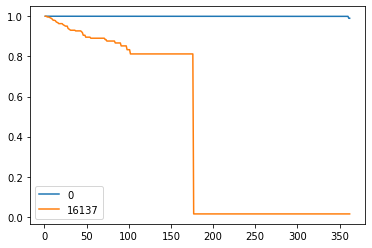

In [781]:
cph.predict_survival_function(x_primer, conditional_after=x_primer['cycle']).plot() 
#cph.predict_median(x_primer)
#cph.predict_partial_hazard(x_primer)
#cph.predict_expectation(x_primer)
print(x_primer_info)

По оси Y - вероятность поломки, по оси Х - кол-во циклов работы до поломки.